# Loan recommendation with Collaborative Filtering

The rating data is in loan_rating.csv, containing lender_id, loan_id, rating. Rating can be from 0-10.

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import random
import csv
from sklearn.model_selection import train_test_split
import locale # for currency formatting
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


loan_rating_df = pd.read_csv("loan_rating.csv",header =0)
loan_rating_df.head()

,lender_id,loan_id,rating
0,0,0,3
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,2


In [2]:
n_lenders = len(loan_rating_df['lender_id'].unique())
n_loans = len(loan_rating_df['loan_id'].unique())

Now a recommender system model from scratch

In [3]:
lenders = loan_rating_df['lender_id'].unique()
n_lenders = len(lenders)
loans = loan_rating_df['loan_id'].unique()
n_loans = len(loans)
Y = np.empty([n_loans, n_lenders])
limit = 100

for loan in loans[:limit]:
    for lender in lenders:
        rating = loan_rating_df[loan_rating_df['loan_id'] == loan][loan_rating_df['lender_id'] == lender]['rating']
        if len(rating) == 0:
            Y[loan,lender] = -1
        else:
            Y[loan,lender] = rating.values[0]
        
        Y = Y.astype(float)

# use just part of Y (like, 100 loans)
Y = Y[:limit,:]
R = (Y != -1)
R = R.astype(float)

In [4]:
pd.DataFrame(Y, columns = ['lender_' + str(i) for i in range(len(Y[0]))], index = ['loan_' + str(i) for i in range(len(Y))]).head()

,lender_0,lender_1,lender_2,lender_3,lender_4,lender_5,lender_6,lender_7,lender_8,lender_9
loan_0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0,0.0,0.0
loan_1,4.0,6.0,0.0,0.0,2.0,7.0,0.0,0.0,9.0,4.0
loan_2,0.0,0.0,0.0,8.0,4.0,8.0,0.0,0.0,0.0,0.0
loan_3,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
loan_4,0.0,4.0,0.0,1.0,0.0,0.0,7.0,7.0,4.0,4.0


In [5]:
loan_df = pd.read_csv("loan.csv",header =0)
loan_df.head()
info = np.array(loan_df)[:limit,:]
loan_df.head()

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
0,5000,36 months,10.65,10.0,RENT,24000.0,credit_card,AZ,27.65,0.0,83.7,9.0,0,26.0,verified
1,2500,60 months,15.27,0.0,RENT,30000.0,car,GA,1.00,0.0,9.4,4.0,1,12.0,verified
2,2400,36 months,15.96,10.0,RENT,12252.0,small_business,IL,8.72,0.0,98.5,10.0,0,10.0,not verified
3,10000,36 months,13.49,10.0,RENT,49200.0,other,CA,20.00,0.0,21.0,37.0,0,15.0,verified
4,5000,36 months,7.90,3.0,RENT,36000.0,wedding,AZ,11.20,0.0,28.3,12.0,0,7.0,verified


Starting here write your own code in these functions

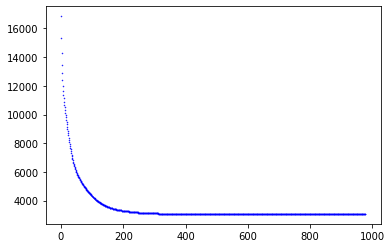


Top 3 recommendations for lender 1:

Predicted rating 6.8 for loan of  $15,000.00  for 36 months with credit_card purpose at 9.9 percent interest

Predicted rating 6.3 for loan of  $9,600.00  for 36 months with other purpose at 7.5 percent interest

Predicted rating 6.2 for loan of  $12,000.00  for 36 months with debt_consolidation purpose at 13.5 percent interest


Top 3 recommendations for lender 2:

Predicted rating 7.3 for loan of  $31,825.00  for 36 months with debt_consolidation purpose at 7.9 percent interest

Predicted rating 7.2 for loan of  $6,200.00  for 36 months with debt_consolidation purpose at 9.9 percent interest

Predicted rating 7.1 for loan of  $6,000.00  for 36 months with debt_consolidation purpose at 8.9 percent interest


Top 3 recommendations for lender 3:

Predicted rating 6.6 for loan of  $15,000.00  for 36 months with debt_consolidation purpose at 9.9 percent interest

Predicted rating 6.2 for loan of  $31,825.00  for 36 months with debt_consolidation purpo

In [6]:
def costFun(param, Y, r, n_lenders, n_loans, n_features, lamba):
    # get X and theta
    # reshape from columns
    X = param[0 : (n_loans * n_features)].reshape([n_loans, n_features], order = "F")
    theta = param[(n_loans * n_features) : ].reshape([n_lenders, n_features], order = "F")
    
    # regularized terms
    C1 = 0.5 * lamba * np.sum(X**2)
    C2 = 0.5 * lamba * np.sum(theta**2)
    
    # cost function 
    J = 0.5 * np.sum(((X @ theta.T - Y) * r)**2) + C1 + C2
    
    return J

def cost_grad(param, Y, r, n_lenders, n_loans, n_features, lamba):    
    # get X and theta
    # reshape from columns
    X = param[0 : (n_loans * n_features)].reshape([n_loans, n_features], order = "F")
    theta = param[(n_loans * n_features) : ].reshape([n_lenders, n_features], order = "F")
    
    # gradient
    # gradient of X, n_loans x n_features
    Xg = ((X @ theta.T - Y) * r) @ theta + lamba * X
    # gradient of theta, n_lenders x n_features
    Tg = ((X @ theta.T - Y) * r).T @ X + lamba * theta
    # flatten, columns
    grad = np.concatenate((Xg.reshape([n_loans * n_features, 1], order = "F"),
                         Tg.reshape([n_lenders * n_features, 1], order = "F")))
    grad = np.squeeze(grad)
    
    return grad
    
def optimizeCost(param, Y, r, n_lenders, n_loans, n_features, lamba, step, maxrun, tol):
    
    convergence = False
    stop = 1
    cost_range = []
    iteration = maxrun
    # gradient descent 
    for i in range(maxrun):
        if (stop >= tol):
            param_old = param
            grad = cost_grad(param_old, Y, r, n_lenders, n_loans, n_features, lamba)
            # update
            param = param_old - step * grad
            # absolute error
            stop = np.sqrt(np.sum((param - param_old)**2))
            # cost 
            cost_range.append(costFun(param, Y, r, n_lenders, n_loans, n_features, lamba))
        else:
            convergence = True
            iteration = i
            break
        
    
    return param, cost_range, convergence, iteration


n_lenders = np.size(Y, 1)
n_loans = np.size(Y, 0)
n_features = 10
# Initialization
X = np.random.normal(loc = 0.0, scale = 1.0, size = (n_loans, n_features))
Theta = np.random.normal(loc = 0.0, scale = 1.0, size = (n_lenders,n_features))
init_param = np.concatenate((X.reshape(n_loans * n_features, 1, order = "F"),
                             Theta.reshape(n_lenders * n_features, 1, order = "F")))
init_param = np.squeeze(init_param)

# Optimization
lamba = 10
maxrun = 10000
step = 0.001
tol = 10**(-8)

param,cost_range,convergence, iteration = optimizeCost(init_param, Y, R, n_lenders, n_loans, \
                     n_features, lamba, step, maxrun, tol)
# now plot the cost
plt.plot(cost_range,"b.",markersize=1,label="Cost") # note: this is 0-based
plt.show()
    
# Extract X and Theta from param vector
X = param[0:(n_loans * n_features)]
Theta = param[(n_loans * n_features):len(param)]
X = X.reshape(n_loans, n_features, order = "F")
Theta = Theta.reshape(n_lenders, n_features, order = "F")
pred = np.dot(X, Theta.T)

# solve the problem of Currency formatting is not possible using the 'C' locale.
locale.setlocale( locale.LC_ALL, 'en_CA.UTF-8' )

# print out top 3 ratings for each lender
top_n = 3
for j in range(n_lenders):
    rating = np.sort(pred[:, j])[::-1]
    ind = np.argsort(pred[:, j])[::-1]
    a = info[ind,:]
    print('\nTop %d recommendations for lender %d:\n' % (top_n, (j+1)))
    for i in range(top_n):
        print('Predicted rating %.1f for loan of  %s  for %s with %s purpose at %.1f percent interest\n' %
        (rating[i], locale.currency(np.float(a[i, 0]),grouping=True), a[i, 1], a[i, 6], np.float(a[i,2])))  